## Import Libraries

In [4]:
# Numerical operations
import numpy as np

# Data handling / paths
import os
import shutil
from glob import glob

# Visualization
import matplotlib.pyplot as plt
import cv2  # optional, for advanced image manipulation

# Deep learning / YOLOv8
from ultralytics import YOLO

# Optional: For progress bars in loops
from tqdm import tqdm

# Optional: For Jupyter notebooks
%matplotlib inline
import os
from glob import glob
from warnings import filterwarnings
filterwarnings("ignore")

## Load Dataset

In [17]:
import os
import numpy as np
from glob import glob

def load_dataset(base_path, dataset_name="Dataset"):
    # Paths
    image_path = os.path.join(base_path, "image")
    label_path = os.path.join(base_path, "label")
    
    # Get all .npy files
    img_files = sorted(glob(os.path.join(image_path, "*.npy")))
    label_files = sorted(glob(os.path.join(label_path, "*.npy")))
    
    # Check if files exist
    if len(img_files) == 0 or len(label_files) == 0:
        print(f"{dataset_name} not loaded! Check your folders.")
        return [], []
    
    # Load files
    images = [np.load(f) for f in img_files]
    labels = [np.load(f) for f in label_files]
    
    # Print success info
    print(f"{dataset_name} loaded successfully!")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels/masks: {len(labels)}")
    print(f"Shape of first image: {images[0].shape}, dtype: {images[0].dtype}")
    print(f"Shape of first label: {labels[0].shape}, dtype: {labels[0].dtype}")
    print(f"Unique classes in first mask: {np.unique(labels[0])}")
    
    return images, labels

# Load datasets
train_images, train_labels = load_dataset(r"F:\Research\RoadSegmentation\data\train", "Train Dataset")
val_images, val_labels = load_dataset(r"F:\Research\RoadSegmentation\data\val", "Validation Dataset")


Train Dataset loaded successfully!
Number of images: 2975
Number of labels/masks: 2975
Shape of first image: (128, 256, 3), dtype: float64
Shape of first label: (128, 256), dtype: float64
Unique classes in first mask: [         -1           0           1           2           5           7           8           9          10          11          12          13          18]
Validation Dataset loaded successfully!
Number of images: 500
Number of labels/masks: 500
Shape of first image: (128, 256, 3), dtype: float64
Shape of first label: (128, 256), dtype: float64
Unique classes in first mask: [         -1           0           1           2           4           5           7           8          10          11          13]


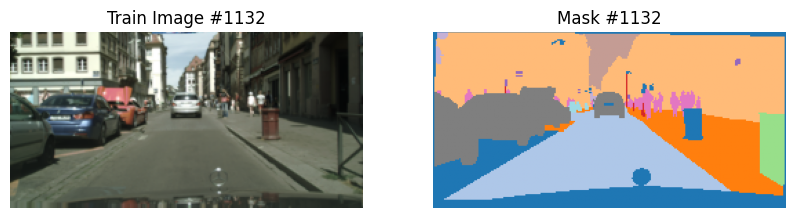

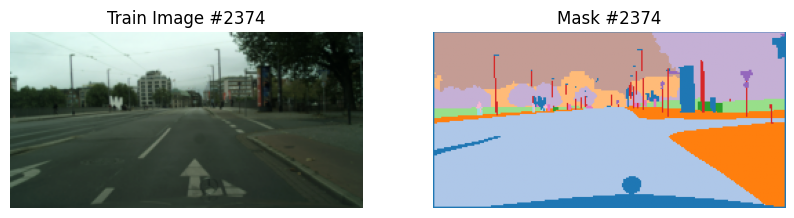

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_samples = 2

for _ in range(num_samples):
    idx = random.randint(0, len(train_images)-1)
    img = train_images[idx]
    mask = train_labels[idx]

    # Normalize image for display
    img_disp = img - np.min(img)
    img_disp = img_disp / np.max(img_disp)
    img_disp = (img_disp * 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title(f"Train Image #{idx}")
    plt.axis("off")

    # Show corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='tab20')
    plt.title(f"Mask #{idx}")
    plt.axis("off")

    plt.show()
